In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
from astropy.io import fits

from utils import load_dict
from low_energy.lowE_deposition import compute_fs
from low_energy.lowE_electrons import make_interpolator

sys.path.append(os.environ['DH_DIR'])
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectools import get_log_bin_width
from darkhistory.spec.spectrum import Spectrum
import darkhistory.physics as phys

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")


In [2]:
abscs = load_dict(f"../data/abscissas/abscs_base.h5")
phot_bin_width = abscs['photE'] * get_log_bin_width(abscs['photE'])
elec_bin_width = abscs['elecEk'] * get_log_bin_width(abscs['elecEk'])

In [22]:
H0 = 1/4.5979401e17
Omega_M = 0.3175
Omega_Lam = 0.6825
Omega_rad = 8e-5
hubble = lambda redshift: H0 * np.sqrt(Omega_M * redshift**3 + Omega_rad * redshift**4 + Omega_Lam)
melec = 510998.903
def elecEk():
    melec = 510998.903
    neng = 500
    dlneng = np.log(5565952217145.328)/neng
    elecbins = melec + np.exp(np.arange(neng+1)*dlneng)
    englow =  elecbins[:-1]
    enghigh = elecbins[1:]
    eng = melec + np.sqrt((englow-melec)*(enghigh-melec)) # electron energies [eV]
    elecbinwidth = enghigh - englow                       # bin width [eV]
    return eng - melec

In [54]:
tf_type = 'phot'

hdul = fits.open(f'ionhist_outputs/debug/{tf_type}_tf_z_3.871E+01_x_1.000E-03_nBs_1.000E+00.fits')

hep_N = np.einsum('sij,j->sij', hdul[1].data['HEP_TF'][0], phot_bin_width)
lep_N = np.einsum('sij,j->sij', hdul[1].data['LEP_TF'][0], phot_bin_width)
lee_N = np.einsum('sij,j->sij', hdul[1].data['LEE_TF'][0], elec_bin_width)
hed_arr = hdul[1].data['hed_tf'][0]
cmbloss = hdul[1].data['cmbloss'][0]
dt = hdul[1].data['dt'][0]
hubblerate = hdul[1].data['hubblerate'][0]
if tf_type == 'phot':
    for i in range(500):
        if lep_N[1, i, i] > 1e-40:
            break
        lep_N[i_step, i, i] = 1.

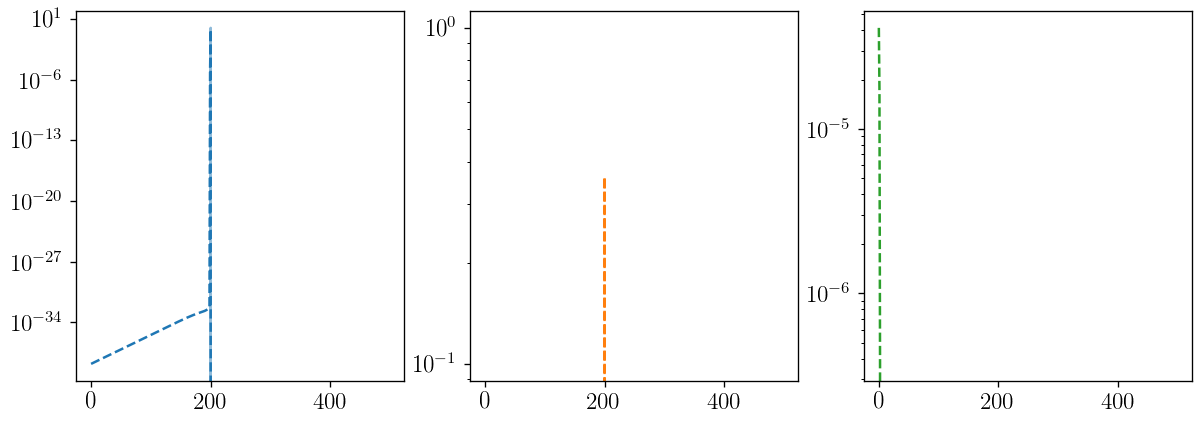

In [55]:
i_injE = 200
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, spec_N in enumerate([hep_N, lep_N, lee_N]):
    axs[i].plot(spec_N[0, i_injE], color=f'C{i}', alpha=0.5)
    axs[i].plot(spec_N[1, i_injE], color=f'C{i}', ls='--')
    axs[i].set(yscale='log')

In [56]:
rs = 38.71318413405
x = 0.0010000000
nBs = 1.0000000000
if tf_type == 'phot':
    inj_E = abscs['photE']
else:
    inj_E = abscs['elecEk'] + melec

In [57]:
f_hep = np.dot(hep_N[1], abscs['photE']) / inj_E
f_lep = np.dot(lep_N[0] + lep_N[1], abscs['photE']) / inj_E
f_lee = np.dot(lee_N[0] + lee_N[1], abscs['elecEk']) / inj_E
f_hed = np.sum(hed_arr[0] * dt[0] + hed_arr[1] * dt[1], axis=1)  / inj_E
f_cmbloss = (cmbloss[0] * dt[0] + cmbloss[1] * dt[1]) / inj_E
f_tot = f_hep + f_lep + f_lee + f_hed - f_cmbloss

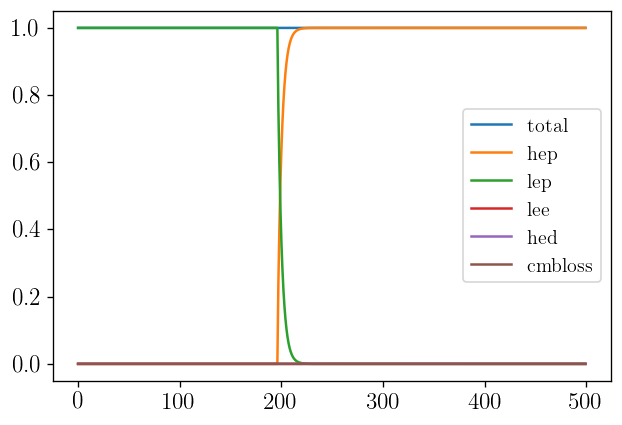

In [58]:
plt.plot(f_tot, color='C0', label='total')
labels = ['hep', 'lep', 'lee', 'hed', 'cmbloss']
for i, f in enumerate([f_hep, f_lep, f_lee, f_hed, f_cmbloss]):
    plt.plot(f, color=f'C{i+1}', label=labels[i])
plt.legend()

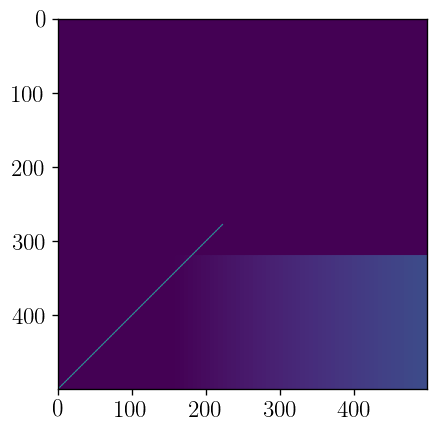

In [59]:
plt.imshow(np.flipud(np.log(np.clip(lep_N[1], 1e-50, None))))

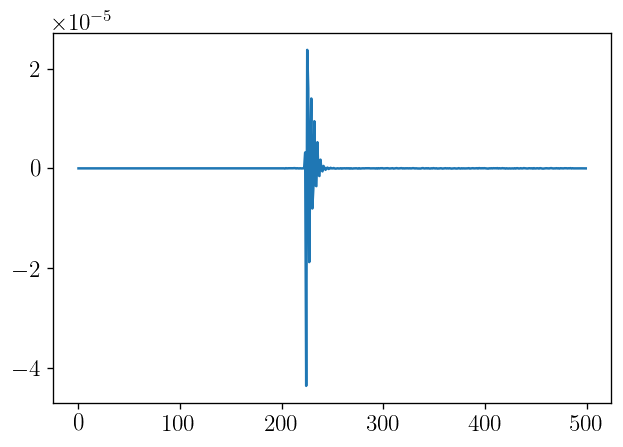

In [60]:
plt.plot(f_tot-1, color='C0')

## Single point: elecEk[200]

In [13]:
# ih_photinput output
photinput = 1542551.8520007003
cmblossprompt = 387351.64484901278
promptdeposition = 125018.46618133254
prompthighdeposition = 55725.135581179587
promptlowengelec = 69293.330600153218 # total(promptlowengelec*(eng-melec))
print((photinput - cmblossprompt + prompthighdeposition + promptlowengelec) / injE)
print((photinput - cmblossprompt + promptdeposition) / injE)

1.0000000050772575
1.0000000050772573


In [33]:
injE = 1280218.6668330203

1280218.6668330203

In [35]:
print(photinput / injE)
print(2 * np.dot(hep_N[200] + lep_N_base[200], abscs['photE']) / injE)
print(2 * np.dot(hep_N[200], abscs['photE']) / injE)
print('-----')
print(- cmblossprompt / injE)
print(- 2 * cmbloss[200]*dt / injE)
print('-----')
print(promptlowengelec / injE)
print(2 * np.dot(lee_N[200], abscs['elecEk']) / injE)
print('-----')
print(prompthighdeposition / injE)
print(np.sum(hed_arr[200]) * dt / injE)
print('-----')

1.2049127949498148
1.2050011003428494
0.7983877178324236
-----
-0.30256678400670073
-0.00013122151707799272
-----
0.05412616797064028
2.4047175702356793e-05
-----
0.043527826163503244
9.43203177252664e-06
-----


## IDL notes

In [ ]:
highdeposited_grid[zstep, *] = highdep_prompt_grid[zstep,*]
highdeposited_grid[zstep,*] += highdep_highenergy_grid[zstep,*]
highdeposited_grid[zstep,*] += highdep_compton_grid[zstep,*] + highdep_cascades_grid[zstep,*]
highdeposited_grid[zstep,*] += highdep_photoion_grid[zstep,*]

In [ ]:
deposited[zstep] =  dep_prompt[zstep]
deposited[zstep] += dep_highenergy[zstep]
deposited[zstep] += comptonengloss + ionengloss + dep_cascades[zstep] 
deposited[zstep] += dep_low[zstep]
deposited[zstep] += dep_low60[zstep] # deposits energy below 60 eV
deposited[zstep] -= total(newionlowphot*photeng)
deposited[zstep] += ioncmbloss

## Make tf

In [ ]:
dlnz = 0.04879016

dt = dlnz / phys.hubble(rs)

MEDEA_dir = '../data/MEDEA'
MEDEA_interp = make_interpolator(prefix=MEDEA_dir)

cmb_un = spectools.discretize(abscs['photE'], phys.CMB_spec, phys.TCMB(rs))
cmb_un_E = cmb_un.toteng()

lep_N = lep_N_base.copy()
if tf_type == 'phot':
    for i in range(500):
        if lep_N[i][i] > 1e-40:
            break
        lep_N[i][i] = 1

f_prop_arr = []
f_lep_prop_arr = []
f_dep_arr = []
f_cmbloss_arr = []
f_tot_arr = []

for i_injE in range(500):

    if tf_type == 'phot':
        injE = abscs['photE'][i_injE]
    elif tf_type == 'elec':
        injE = abscs['elecEk'][i_injE] + phys.me

    hep_spec_N = hep_N[i_injE]

    cmb_E = cmbloss[i_injE] * dt
    print(cmb_E / injE)
    hep_spec_N += (-cmb_E/cmb_un_E) * cmb_un.N

    lep_spec_N = lep_N[i_injE]
    lee_spec_N = lee_N[i_injE]

    lowengelec_spec_at_rs = Spectrum(abscs['elecEk'], lee_spec_N, spec_type='N')
    lowengelec_spec_at_rs.rs = rs

    lowengphot_spec_at_rs = Spectrum(abscs['photE'], lep_spec_N, spec_type='N')
    lowengphot_spec_at_rs.rs = rs

    highengdep_at_rs = hed_arr[i_injE]

    #==============================
    # Compute f's
    x_vec_for_f = np.array( [1-x, phys.chi*(1-x), phys.chi*x] ) # [HI, HeI, HeII]/nH
    nBs_ref = 1
    dE_dVdt_inj = injE * phys.nB * nBs_ref * rs**3 / dt # [eV/cm^3 s]
    # in DH.main: (dN_inj/dB) / (dE_inj  /dVdt)
    # here:       (dN_inj   ) / (dE_injdB/dVdt)
    f_low, f_high = compute_fs(
        MEDEA_interp=MEDEA_interp,
        rs=rs,
        x=x_vec_for_f,
        elec_spec=lowengelec_spec_at_rs,
        phot_spec=lowengphot_spec_at_rs,
        dE_dVdt_inj=dE_dVdt_inj,
        dt=dt,
        highengdep=highengdep_at_rs,
        cmbloss=0, # turned off in darkhistory main as well
        method='no_He',
        cross_check=False,
        ion_old=False
    )
    f_raw = f_low + f_high

    #==============================
    # Compute tf & f values
    move_loweng_prop = True
    if move_loweng_prop:
        lep_prop_spec_N = lep_spec_N * (abscs['photE'] < 10.2) # [eV]
        f_lep_prop = np.dot(abscs['photE'], lep_prop_spec_N) / injE
        phot_spec_N = hep_spec_N + lep_prop_spec_N
        f_prop = np.dot(abscs['photE'], phot_spec_N) / injE

        f_dep = f_raw
        f_dep[4] -= f_lep_prop # adjust for the propagating lowengphot
        f_tot = f_prop + np.sum(f_dep)
    else:
        f_prop = np.dot(abscs['photE'], hep_spec_N) / injE
        f_lep_prop = np.dot(abscs['photE'], lep_spec_N) / injE
        f_dep = f_raw
        f_tot = f_prop + np.sum(f_dep)

    f_prop_arr.append(f_prop)
    f_lep_prop_arr.append(f_lep_prop)
    f_dep_arr.append(f_dep)
    f_cmbloss_arr.append(cmbloss[i_injE] / injE)
    f_tot_arr.append(f_tot)

    #==============================
    # Fix energy conservation (known issues)
    # if tf_type == 'phot':
    #     if i_injE == 153: # issue at around 13.6 eV. Adjusting H_ion.
    #         f_dep[0] += 1 - f_tot
    #     if i_injE in range(224, 228): # ??? issue. Adjusting hep propagating bin.
    #         phot_spec_N[i_injE] += 1 - f_tot

    #==============================
    # Energy conservation
    # f_dep_str = ' '.join([f'{v:.3e}' for v in f_dep])
    # print_str = f'{n_run} | {i_rs} {i_x} {i_nBs} {i_injE} | f_prop={f_prop:.6f} f_dep={f_dep_str} f_tot={f_tot:.6f}'
    # if np.abs(f_tot - 1.) > 1e-2:
    #     print_str += ' | Energy error > 1%'
    # if verbose >= 1 or np.abs(f_tot - 1.) > 1e-2:
    #     print(print_str, flush=True)
    
    # phot_spec_N[i_injE] += 1 - f_tot # gives all extra energy to propagating photons

In [18]:
abscs['dep_c']

array([b'H ion', b'He ion', b'exc', b'heat', b'cont'], dtype=object)

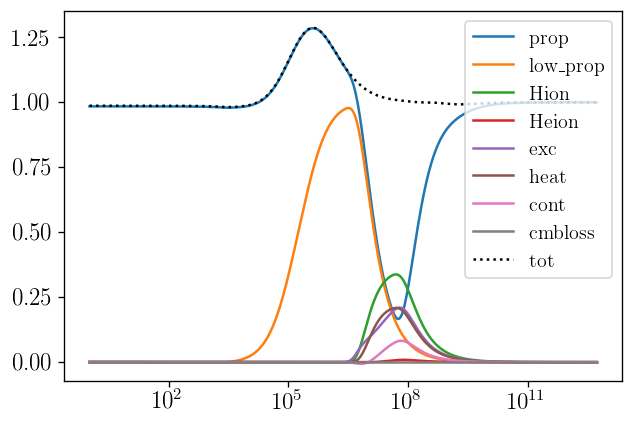

In [19]:
f_Hion_arr, f_Heion_arr, f_exc_arr, f_heat_arr, f_cont = np.array(f_dep_arr).T

injE_abscs = abscs['photE'] if tf_type == 'phot' else abscs['elecEk']

plt.plot(injE_abscs, f_prop_arr, label='prop')
plt.plot(injE_abscs, f_lep_prop_arr, label='low_prop')
plt.plot(injE_abscs, f_Hion_arr, label='Hion')
plt.plot(injE_abscs, f_Heion_arr, label='Heion')
plt.plot(injE_abscs, f_exc_arr, label='exc')
plt.plot(injE_abscs, f_heat_arr, label='heat')
plt.plot(injE_abscs, f_cont, label='cont')
plt.plot(injE_abscs, f_cmbloss_arr, label='cmbloss')
plt.plot(injE_abscs, f_tot_arr, 'k:', label='tot')
if tf_type == 'phot':
    plt.axvline(10.2, c='gray', alpha=0.2)
    plt.axvline(511000, c='gray', alpha=0.2)
plt.xscale('log')
plt.legend()